# GPe model development notes

## 28th May 2015

The GPe model is based on Izhikevich's 2003 paper – the resonator model, with a small change to the C parameter to induce zero-current spiking..

Model is same as Izhikevich 2003, with parameters as below.

The model exhibits zero current spiking at around the right frequency, an afterhyperpolarization membrane voltage dip and a reasonable frequency/current graph.

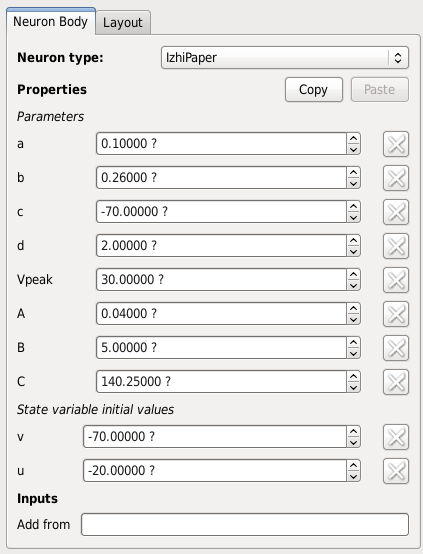

In [1]:
from IPython.display import Image
Image(filename='GPe_parameters.png')

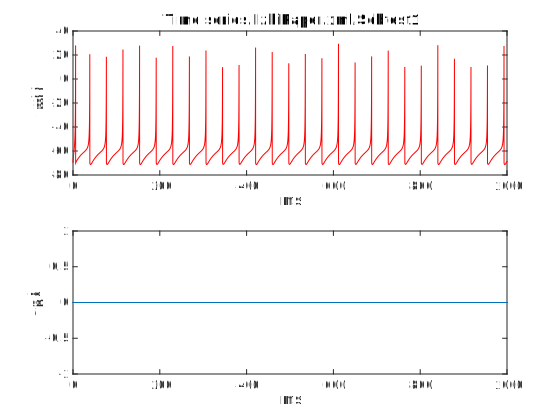

In [3]:
from IPython.display import SVG
#zero current
SVG(filename='gpe_zero_current.svg')

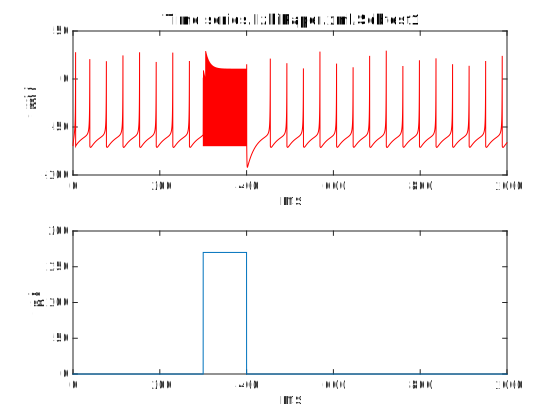

In [4]:
# After-hyperpolarization
SVG(filename='gpe_afterhyperpolarization.svg')

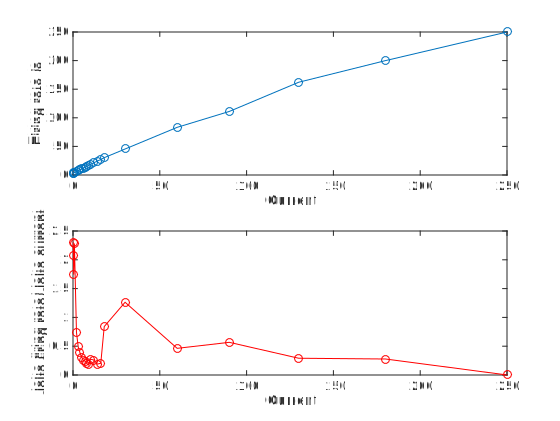

In [5]:
# firing vs current NB! Factor of 10 wrong on firing rate here!!!
SVG('gpe_firing_vs_current.svg')

## 12th June 2015. Running the GPe ABC model

I decided to go with the ABC model form for the STN model, and will also use this for the GPe model for now.

## Model definition

$${\dot{v}\over T}=Av^2+Bv+C-u+{I\over S_I}$$
$${\dot{u}\over T}=a(bv-u)$$
$$v>v_{peak}: v\leftarrow c, u \leftarrow u+d$$

##Model parameters
The parameters for the model are in the code block below:

In [7]:
# Here are the GPe model parameters
_a=0.1; _b=0.26; _c=-70; _d=2;
_vpeak=30; _A=0.04; _B=5; _C=140.25; _T=1; _SI=8;
_vinit=-70; _uinit=-10;

## Modify then run and visualise the GPe ABC model

This code will define parameters in the SpineML model description, then run and visualise that model. If run with default parameters, then it will show the model with parameters as defined above (_a, _b, etc).

In [2]:
# *Modify* the model then run it and finally analyse it.
def explore_abc_model (constI=0, a=_a, b=_b, c=_c, d=_d, 
                       vpeak=_vpeak, A=_A, B=_B, C=_C, T=_T, SI=_SI,
                       lowerV=-90, upperV=-20, qvloweru=-25, qvupperu=0, 
                       qpspacing=4, qpveclen=200, vinit=_vinit, uinit=_uinit):

    import sys
    sys.path.append("../analysis")

    # Where's the model and data?
    modeldir = '/home/seb/izhibg/abrg_local/IzhiBG/Izhi_GPe';
    expt = 0;
    population = 'Sebtest1'
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemltmp = spineml2brahms+'/temp/log/';

    # Modify the model xml
    import update_abc_model_xml as abcupdate
    abcupdate.update_abc_model_xml (modeldir,expt,a,b,c,d,A,B,C,T,SI,vpeak,vinit,uinit)

    # Execute the model
    import os
    spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
                 'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
                 `expt`+' -c'+population+':I:'+`constI`+' ; popd"';
    os.system(spinemlcmd);

    # load the data from the model run
    import load_sc_data as lsd
    v, v_count, t, nn, dt = lsd.load_sc_data (spinemltmp+population+'_v_log.bin');
    u, u_count, tu, nnu, dtu = lsd.load_sc_data (spinemltmp+population+'_u_log.bin');

    import numpy as np

    # Compute nullclines
    I = np.zeros(v_count)+constI;
    Vn = np.linspace (lowerV, upperV, 1000);
    nc_v = A*np.power(Vn, 2)+ B*Vn + C + I[:len(Vn)]/SI;
    nc_u = Vn*b;

    # Compute vector field
    if qpspacing != 0:
        thescale = abs(lowerV-upperV)/qpspacing;
        Vgv = np.linspace(lowerV, upperV, thescale);
        ugv = np.linspace(qvloweru, qvupperu, thescale);
        Vg, ug = np.meshgrid(Vgv, ugv);
        vdot = T*A*Vg*Vg + T*B*Vg + T*C - T*ug + T*I[:len(Vg)]/SI;
        udot = T*a*(b*Vg - ug);
    
    # Plot the computed data
    %matplotlib inline
    import plot_izhi as pizhi
    pizhi.plot_izhi ('GPe ABCT model phase plot', v, u, Vn, nc_v, nc_u, Vg, ug, vdot, udot,
                     lowerV, upperV, qvloweru, qvupperu, qpspacing, qpveclen)
    
    # Now plot the time series
    import matplotlib.pyplot as plt
    plt.figure(figsize=(18,10))
    plt.clf;
    plt.plot (t, v, linewidth=4)
    #plt.title('GPe ABCT model spikes',fontsize=48,y=1.05)
    plt.xlabel('t (ms)',fontsize=48)
    plt.ylabel('v',fontsize=48)
    plt.tick_params(axis='x', labelsize=32, pad=10)
    plt.tick_params(axis='y', labelsize=32, pad=10)
    plt.savefig('/home/seb/izhibg/abrg_local/IzhiBG/labbook/GPe_ABCT_tseries.svg')
    plt.show()

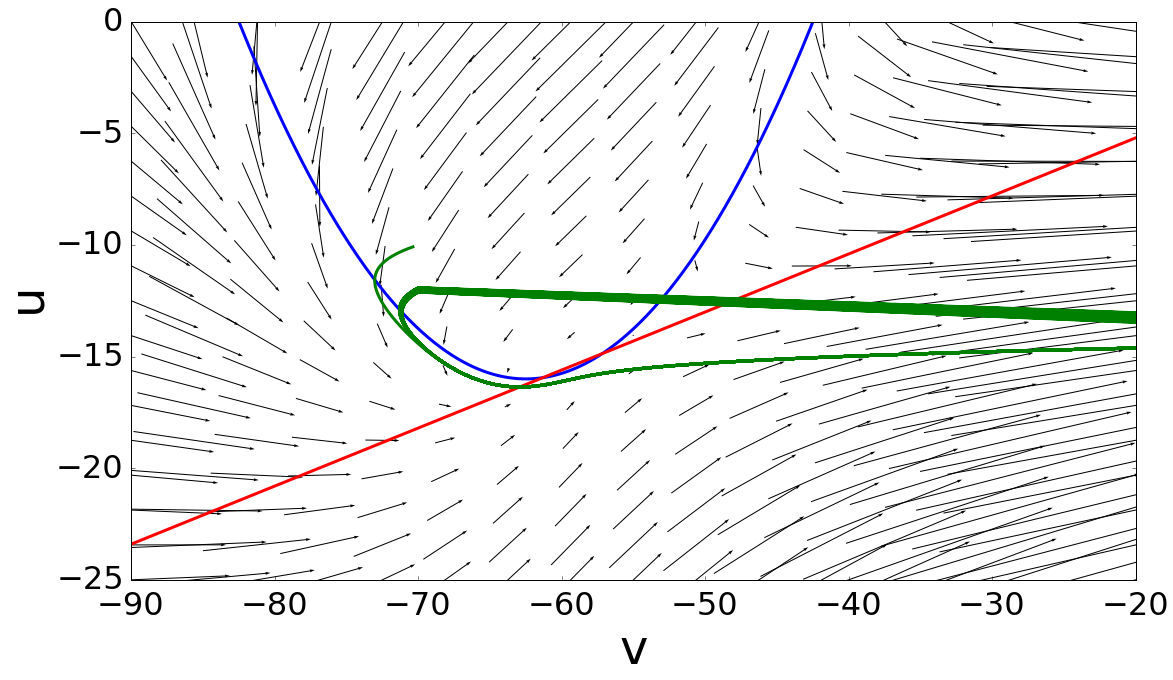

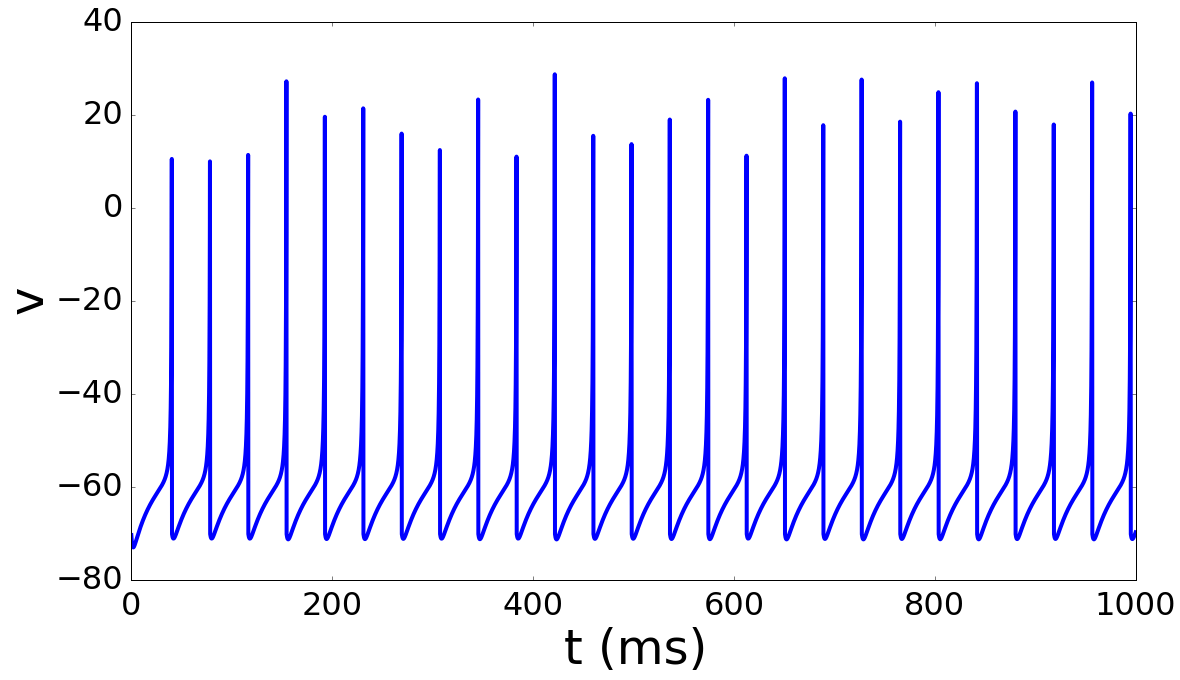

In [3]:
from IPython.html.widgets import interact

interact(explore_abc_model,
         vpeak=(20,40,1),
         lowerV=(-150,-40,1),
         upperV=(-40,60,1),
         qvloweru=(-60,0,1),
         qvupperu=(-6,40,1),
         qpspacing=(0,6,0.1),
         qpveclen=(10,300,10),
         constI=(-100,100,0.5),
         a=(0.02,2,0.0001),
         b=(0.100,0.300,0.001),
         c=(-120,30,1),
         d=(0,5,0.01),
         T=(0.0,10.0,0.1),
         A=(0.03,0.05,0.0001),
         B=(3,5,0.01),
         C=(100,150,0.1),
         vinit=(-120,30,.1),
         uinit=(-20,10,.1));

##Read, run and visualise the GPe model¶
This aids in visualising experiments defined in SpineCreator.

In [4]:
# *Read* the model then run it and finally analyse it.
def run_abc_model (expt=0, lowerV=-80, upperV=-20, qvloweru=-16, qvupperu=-10,
                   qpspacing=3, qpveclen=70):

    # Where's the model and data?
    modeldir = '/home/seb/izhibg/abrg_local/IzhiBG/Izhi_GPe';
    population = 'Sebtest1';
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemltmp = spineml2brahms+'/temp/log/';

    # Modify the model xml
    import read_abc_model_xml as abcread
    a,b,c,d,A,B,C,T,vpeak,vinit,uinit = abcread.read_abc_model_xml (modeldir,expt)
    
    # Execute the model
    import os
    spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
                 'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
                 `expt`+' ; popd"'; # omit: +' -c'+population+':I:'+`constI`
    os.system(spinemlcmd);

    # load the data from the model run
    import load_sc_data as lsd
    v, v_count, t, nn, dt = lsd.load_sc_data (spinemltmp+population+'_v_log.bin');
    u, u_count, tu, nnu, dtu = lsd.load_sc_data (spinemltmp+population+'_u_log.bin');

    import numpy as np

    # Temporary hack - better to get this from experiment xml,
    # but what's to say it isn't a time varying current?
    constI = 0
    
    # Compute nullclines
    Vn = np.linspace (lowerV, upperV, 1000);
    I = np.zeros(v_count)+constI;
    nc_v = A*np.power(Vn, 2)+ B*Vn + C + I[:len(Vn)];
    nc_u = Vn*b;

    # Compute vector field
    if qpspacing != 0:
        thescale = abs(lowerV-upperV)/qpspacing;
        Vgv = np.linspace(lowerV, upperV, thescale);
        ugv = np.linspace(qvloweru, qvupperu, thescale);
        Vg, ug = np.meshgrid(Vgv, ugv);
        vdot = T*A*Vg*Vg + T*B*Vg + T*C - T*ug + T*I[:len(Vg)];
        udot = T*a*(b*Vg - ug);
    
    # Plot it.
    %matplotlib inline
    import plot_izhi as pizhi
    pizhi.plot_izhi ('GPe ABCT model phase plot AHP', v, u, Vn, nc_v, nc_u, Vg, ug, vdot, udot,
                     lowerV, upperV, qvloweru, qvupperu, qpspacing, qpveclen)
    
    # Now plot the time series
    import matplotlib.pyplot as plt
    plt.figure(figsize=(18,10))
    plt.clf;
    plt.plot (t, v, linewidth=4)
    #plt.title('GPe ABCT model spikes and after-hyperpolarization',fontsize=48,y=1.05)
    plt.xlabel('t (ms)',fontsize=48)
    plt.ylabel('v',fontsize=48)
    plt.tick_params(axis='x', labelsize=32, pad=10)
    plt.tick_params(axis='y', labelsize=32, pad=10)
    plt.savefig('/home/seb/izhibg/abrg_local/IzhiBG/labbook/GPe_ABCT_tseries_ahp.svg')
    plt.show()

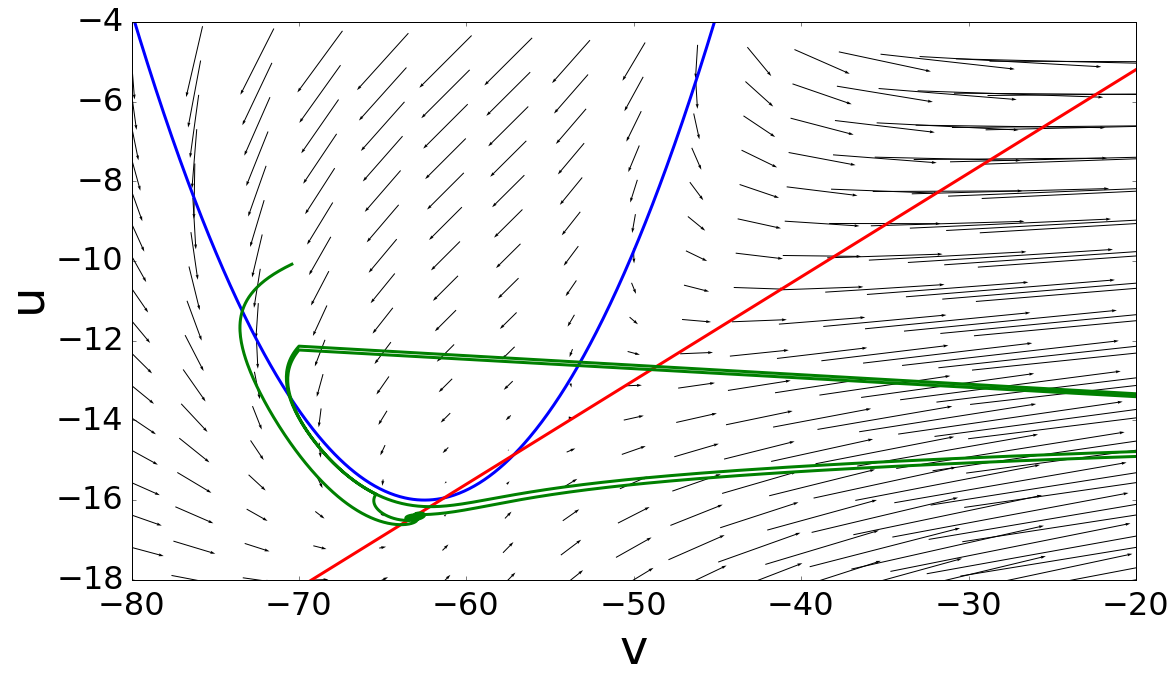

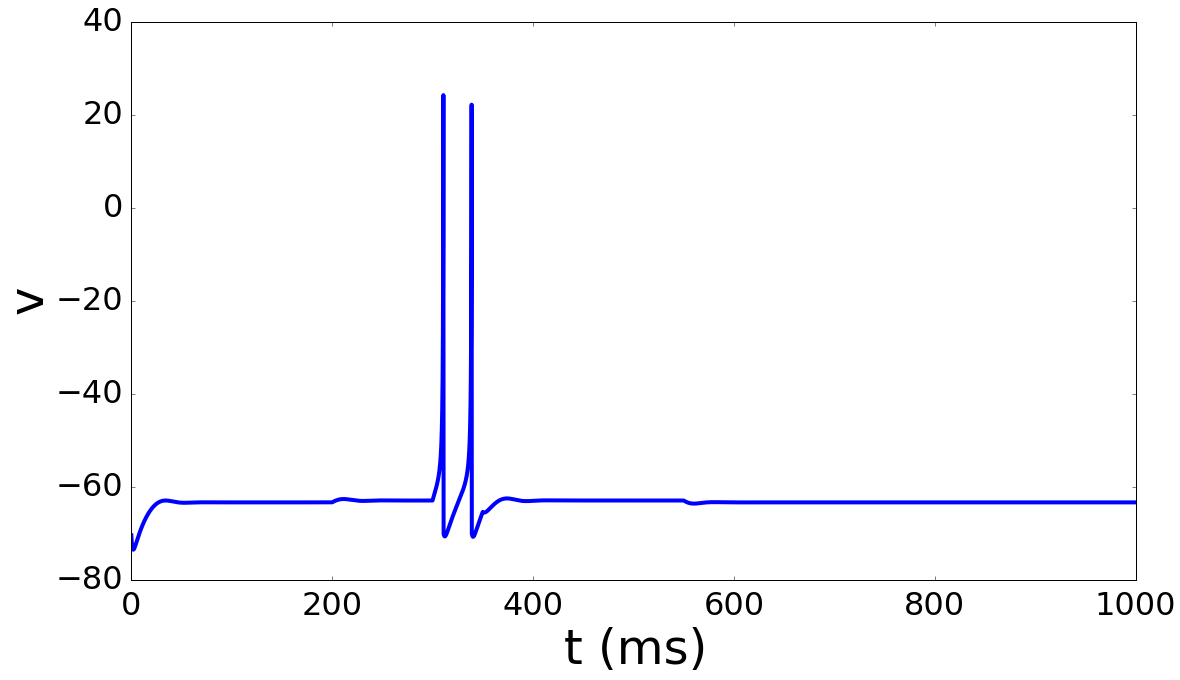

In [5]:
from IPython.html.widgets import interact

interact(run_abc_model,
         expt=(0,5,1),
         lowerV=(-120,-40,1),
         upperV=(-40,60,1),
         qvloweru=(-20,0,1),
         qvupperu=(-6,10,1),
         qpspacing=(0,10,0.5),
         qpveclen=(10,300,10))

## Produce firing rate vs. current for ABC GPe model

In [8]:
# Do a sweep through the currents with a given set of parameters.
def abc_gpe_rate_sweep (constIlist):
    # Set your parameters here...
    expt = 0;
    population='Sebtest1'
    a=_a; b=_b; c=_c; d=_d
    vpeak=_vpeak;
    A=_A; B=_B; C=_C; T=_T; SI=_SI;
    #lowerV=-80; upperV=-20; qvloweru=-16; qvupperu=-10
    vinit=_vinit; uinit=_uinit
    # Where's the model and data?
    modeldir = '/home/seb/izhibg/abrg_local/IzhiBG/Izhi_GPe';
    spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS';
    spinemltmp = spineml2brahms+'/temp/log/';

    # Modify the model xml
    import update_abc_model_xml as abcupdate
    abcupdate.update_abc_model_xml (modeldir,expt,a,b,c,d,A,B,C,T,SI,vpeak,vinit,uinit)

    # Execute the model
    import os
    import load_sc_data as lsd
    import firing_rate as fr

    # Put this in a loop, and do some analysis to extract the firing rate from the output.
    rates=[];
    isiRates=[];
    for constI in constIlist:
        spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && ' \
            +'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e' \
            +`expt`+' -c'+population+':I:'+`constI`+' ; popd"';
        os.system(spinemlcmd);

        # load the data from the model run
        v, v_count, t, nn, dt = lsd.load_sc_data (spinemltmp+population+'_v_log.bin');
        u, u_count, tu, nnu, dtu = lsd.load_sc_data (spinemltmp+population+'_u_log.bin');
    
        rate, isiRate = fr.firing_rate (v, t[len(t)-1], 0.1)
        print 'rate:', rate, ' isiRate:', isiRate
        rates.append(rate);
        isiRates.append(isiRate);

    return rates, isiRates


rate: 26.00260026  isiRate: 26.1991132608
rate: 26.00260026  isiRate: 26.6584640623
rate: 27.00270027  isiRate: 27.5173257236
rate: 29.00290029  isiRate: 30.0144897537
rate: 35.00350035  isiRate: 35.5546525803
rate: 49.00490049  isiRate: 50.051072523
rate: 86.0086008601  isiRate: 87.1327254306
rate: 217.02170217  isiRate: 222.586931993
rate: 345.03450345  isiRate: 358.069538142
rate: 455.04550455  isiRate: 477.189302569


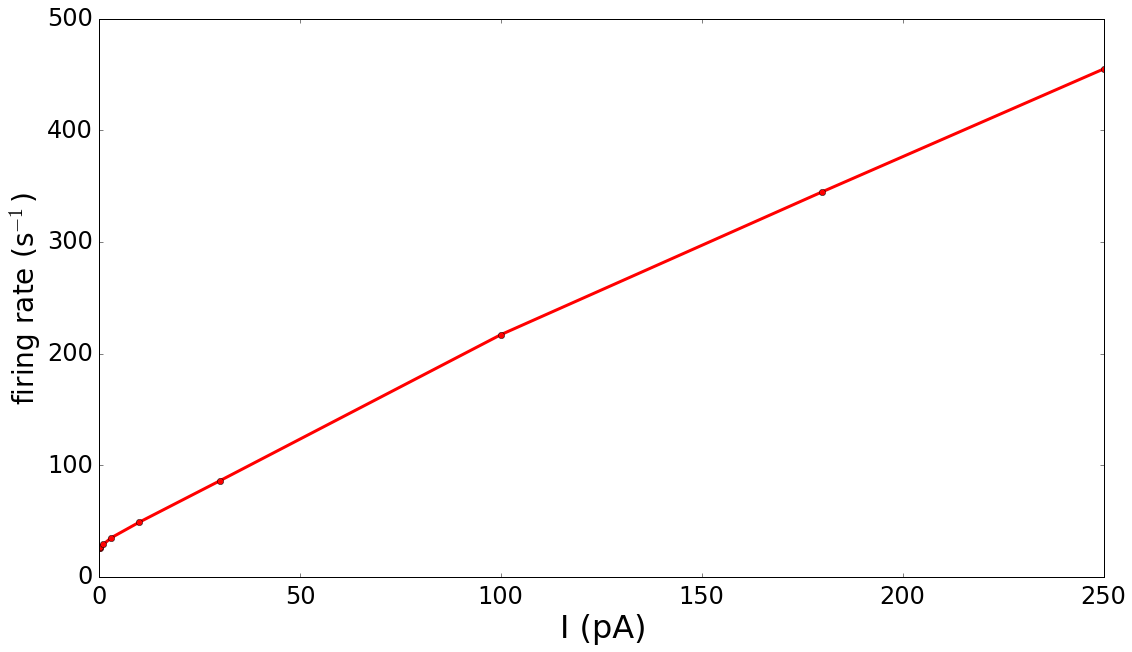

In [9]:
constIlist = [0, 0.1, 0.3, 1, 3, 10, 30, 100, 180, 250]
rates, isiRates = abc_gpe_rate_sweep(constIlist)
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(18,10))
plt.clf;

#plt.plot (constIlist, rates, color='r')
#plt.plot (constIlist, isiRates, color='b')
#plt.xlabel('I')
#plt.ylabel('Firing rate per second')

plt.plot (constIlist, rates, color='r', marker='o', label='Model',linewidth=3)
#plt.plot (constIlist, isiRates, color='b')
# Load BevanWilson data.
#BW = np.loadtxt(open("./published_data/STN/Bevan_Wilson_Fig_6b.csv","rb"),delimiter=",",skiprows=1)
#plt.plot (BW[:,0], BW[:,1], marker='o', color='g', label='Bevan & Wilson data',linewidth=3)
plt.xlabel('I',fontsize=32)
plt.ylabel('Firing rate per second',fontsize=32)
#plt.title('STN ABCTSigI model f-I curve',fontsize=28,y=1.05)
plt.xlabel('I (pA)',fontsize=32)
plt.ylabel('firing rate (s$^{-1}$)',fontsize=28)
plt.tick_params(axis='x', labelsize=24, pad=8)
plt.tick_params(axis='y', labelsize=24, pad=8)
#plt.legend(loc=4,fontsize=22)
plt.savefig('/home/seb/izhibg/abrg_local/IzhiBG/labbook/GPe_f-I.svg')
plt.show()

In [14]:
# Compute parameters for IzhiABCTFast component:
AT=_A*_T
BT=_B*_T
CT=_C*_T
aT=float(_a)*_T
ToverSI=float(_T)/_SI
print 'AT=',AT,'BT=',BT,'CT=',CT,'aT=',aT,'ToverSI=',ToverSI

AT= 0.04 BT= 5 CT= 140.25 aT= 0.1 ToverSI= 0.125


##2015-07-02

I'm reading about dendrite/axon morphology (see the main model labbook) and I've found some interesting papers about GPe.

See Zotero/Izhikevich modelling/GPe for:

* Cooper & Stanford, *Electrophysiological and morphological characteristics of three subtypes of rat globus pallidus neurone in vitro*, which describes differences between 296 GP neurons in slices.
* Gunay et al., *Channel Density Distributions Explain Spiking Variability in the Globus Pallidus: A Combined Physiology and Computer Simulation Database Approach* for a description of where the variability may come from.
* Savio-Chan et al., *HCN2 and HCN1 Channels Govern the Regularity of Autonomous Pacemaking and Synaptic Resetting in Globus Pallidus Neurons* reminds me that there are both Cholinergic interneurons and GABAergic projection neurons in the GP.

On tonic or spontaneous activity, here's a sentence from Savio-Chan et al. (from Surmeier's lab):

*in-vitro studies have shown that presumed GP projection neurons are capable of autonomous, pacemaker activity (Nambu and Llinas, 1994, 1997; Cooper and Stanford, 2000; Stanford, 2003)*

*In vivo, GP neurons display a tonic, high-frequency discharge that is interrupted by pauses*

Nambu & Llinas 1997 states that of the type I type II and type III neurons in GP, I and II are projection neurons (in some cases projecting to Striatum); type III appears to be an interneuron.

NB: type A Cooper & Stanford == type II Nambu & Llinas. These make up 63% of GP neurons (Stanford 2003).

Type A cells seem to act as independent oscillators, with slightly differing frequencies (Stanford 2003).

For a nice review, see Kita, "Globus pallidus external segment", Ch 7 in Prog. in Brain. Res. Vol 160. (GABA and the Basal Ganglia), which we have in the ABRG office. From this review:

* Majority of GPe neurons are GABAergic projection neurons which contain glutamate decarboxylase. [Glutamate decarboxylase (GAD) catalyzes the production of γ-aminobutyric acid (GABA)]
* 1/3 of GPe neurons project to Str.
* Both striatal & non-striatal projecting neurons also project to GPi and STN (in rat?). In monkeys, striatal projecting GPe neurons do not project to any other nucleus.
* Interneurons are small in relative proportion and contain calretinin, a binding protein which makes these neurons likely to bind with other GABAergic neurons. 1% according to Cooper & Stanford 2002.
* GPe neurons but not striatal neurons are spontaneously active in slice preparations at relatively high rates (Ogura and Kita 2000, Matsui and Kita, 2003, Kaneda and Kita 2005)
* Large IPSCs usually due to interneurons, which bind at soma or on proximal dendrites. Smaller IPSCs seen for connections from Striatum.
* Kita says GPe neurons are spontaneously active in slice preparations.

Is Kita's "striatal projecting" and "non-striatal projecting" types equivalent to Stanford's/Llinas's types A/B or C?

###2015-12-06
Savio-Chan et al., HCN2 and HCN1 Channels Govern... suggests that GP/GPe neurons are spontaneously active, even with STN afferents lesioned. This paper has conductance information for HCN channels (Hyperpolarization activated, cyclic nucleotide gated cation channels.